# The Daubechies D4 Wavelet Tranform

In [141]:
import numpy as np
import cv2
import IPython
from PIL import Image
import matplotlib.pyplot as plt


def split_matrix(matrix): # divide the matrix into 4 quadrants
    leftSide, rightSide = np.split(matrix, 2, axis=1)
    appr, vD = np.split(leftSide, 2, axis=0)
    hD, dD = np.split(rightSide, 2, axis=0)
    
    return p_new(appr), p_new(hD), p_new(vD), p_new(dD)

def imshow(image, width=None):
    _, ret = cv2.imencode('.jpg', image)
    i = IPython.display.Image(data=ret, width=width)
    IPython.display.display(i)

def jpg_to_pgm(jpg_path):
    image = Image.open(jpg_path)
    image_gray = image.convert('L')
    width = image_gray.size[0]
    if (width>512):
        image_gray = image_gray.resize((512, 512))
        pixels = list(image_gray.getdata())

    else: pixels = list(image_gray.getdata())

    return np.array(pixels).reshape((512, 512))

def p_new(matrix):
    max,min  = np.max(matrix), np.min(matrix)
    for i in range(len(matrix)):
        for j in range(len(matrix[i])):
            matrix[i][j] = ((matrix[i][j]-min)*255.0)/(max-min)
    return matrix

In [142]:
def function_daubechies_coeffs(image):
    rows, cols = image.shape
    matrix_coeffs = np.zeros((rows, cols))

    for i in range(rows // 2):
        if i < rows // 2 - 1:
            matrix_coeffs[i, 2 * i:2 * i + 4] = h_coeffs
        else:
            matrix_coeffs[i, 2 * i:2 * i + 2] = h_coeffs[:2]
            matrix_coeffs[i, 0:2] = h_coeffs[2:]

    for i in range(rows // 2):
        if i < rows // 2 - 1:
            matrix_coeffs[i + rows // 2, 2 * i:2 * i + 4] = g_coeffs
        else:
            matrix_coeffs[i + rows // 2, 2 * i:2 * i + 2] = g_coeffs[:2]
            matrix_coeffs[i + rows // 2, 0:2] = g_coeffs[2:]

    return (np.round(matrix_coeffs, 4))

def daubechies4_wavelet_transform_2D(daubechies_coeffs,image,scale,width):
    result_H = []
    dH,dV,dD = [],[],[]

    print("Entré")
    for row in image: #ESTA PARTE HACE LA HORIZONTAL
        result_H.append(np.dot(daubechies_coeffs,row))
    result_V = np.dot(daubechies_coeffs,result_H)
    if (scale == 1) :
        return result_V
    
    elif (np.log2(width//4) >= scale > 1):
        image = result_V[:width//2,:width//2]
        new_daubechies = function_daubechies_coeffs(image)
        return daubechies4_wavelet_transform_2D(new_daubechies,image,scale-1,image.shape[0])

    else : print(f"The scale value has to be between 1 - {np.log2(width//4)} ")
        


def inverse_daubechies4_wavelet_transform_2D(daubechies_coeffs, result_V):
    daubechies_coeffs_transpose = np.transpose(daubechies_coeffs)
    result_H = np.dot(daubechies_coeffs_transpose, result_V)

    image = []
    for row in result_H:
        original_row = np.dot(daubechies_coeffs_transpose, row)
        image.append(original_row)

    return np.array(image)

root2, root3 = np.sqrt(2), np.sqrt(3) 

h_coeffs = np.array([(1 + root3) / (4 * root2),
                     (3 + root3) / (4 * root2),
                     (3 - root3) / (4 * root2),
                     (1 - root3) / (4 * root2)])

g_coeffs = np.array([h_coeffs[3], 
                    -h_coeffs[2],
                     h_coeffs[1], 
                    -h_coeffs[0]])

In [143]:
example = np.random.randint(0.0, 52.0, (8, 8))
example_daubechies_4 = function_daubechies_coeffs(example)
example_daubechies_4_transposed = np.transpose(example_daubechies_4)
print(f"\nCoeffs Matrix:\n {example_daubechies_4}")
print(f"\nCoeffs Matrix Transposed:\n {example_daubechies_4_transposed}")



Coeffs Matrix:
 [[ 0.483   0.8365  0.2241 -0.1294  0.      0.      0.      0.    ]
 [ 0.      0.      0.483   0.8365  0.2241 -0.1294  0.      0.    ]
 [ 0.      0.      0.      0.      0.483   0.8365  0.2241 -0.1294]
 [ 0.2241 -0.1294  0.      0.      0.      0.      0.483   0.8365]
 [-0.1294 -0.2241  0.8365 -0.483   0.      0.      0.      0.    ]
 [ 0.      0.     -0.1294 -0.2241  0.8365 -0.483   0.      0.    ]
 [ 0.      0.      0.      0.     -0.1294 -0.2241  0.8365 -0.483 ]
 [ 0.8365 -0.483   0.      0.      0.      0.     -0.1294 -0.2241]]

Coeffs Matrix Transposed:
 [[ 0.483   0.      0.      0.2241 -0.1294  0.      0.      0.8365]
 [ 0.8365  0.      0.     -0.1294 -0.2241  0.      0.     -0.483 ]
 [ 0.2241  0.483   0.      0.      0.8365 -0.1294  0.      0.    ]
 [-0.1294  0.8365  0.      0.     -0.483  -0.2241  0.      0.    ]
 [ 0.      0.2241  0.483   0.      0.      0.8365 -0.1294  0.    ]
 [ 0.     -0.1294  0.8365  0.      0.     -0.483  -0.2241  0.    ]
 [ 0.      0.   

In [144]:
print(f"Original Matrix:\n {example}\n")
dwt = daubechies4_wavelet_transform_2D(example_daubechies_4,example,1,example.shape[0])
# idwt = inverse_daubechies4_wavelet_transform_2D(example_daubechies_4,dwt)
print(f"\nDirect Daubechies Wavelet Transform:\n {np.round(dwt,1)}")
# print(f"\nDirect Daubechies Wavelet Transform:\n {np.round(idwt,0)}")


Original Matrix:
 [[14 47  5 17 25 20 26  6]
 [39 40 14 13 11 51 35 39]
 [47 38 18 31 26 25  7  9]
 [43 32 38 43 46 35  9 11]
 [34 27 16 11  6  7 45 21]
 [32  4 13  3 10 37 46 44]
 [12 42  8  3 42 50  9 48]
 [42 46 32 35 13 22 49 51]]

Entré

Direct Daubechies Wavelet Transform:
 [[ 72.4  21.3  59.7  52.7 -18.1 -14.4   3.2  -5.7]
 [ 75.   71.3  58.3  25.1  -9.5   7.   -8.6  22.8]
 [ 39.3   9.9  50.8  76.2   2.   -7.7  10.    5.6]
 [ 74.9  44.6  53.3  75.  -10.2  -1.2  -4.6 -18.3]
 [  3.3  -3.5 -12.6  -9.2  -7.3   0.6  -1.5   9. ]
 [  5.8  -6.8 -22.1  -1.8  -1.8   1.7  20.9  -6.4]
 [ -4.4 -17.5  23.3 -19.1  -2.6  16.5 -36.7 -18.9]
 [ -7.6  -1.3 -10.2 -34.4  -7.5  16.8  12.5  -9.2]]


## IMAGES EXAMPLES

In [145]:
photo = 'imagen.jpg'

array_photo = jpg_to_pgm(photo)
array_photo.shape[0]

512

Entré


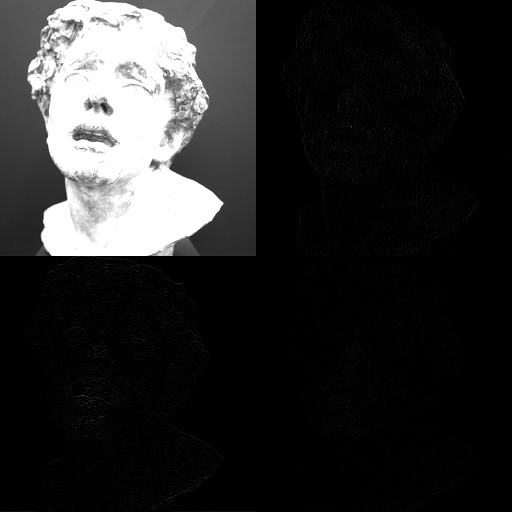

Text(0.5, 1.0, 'Daubechies Transform')

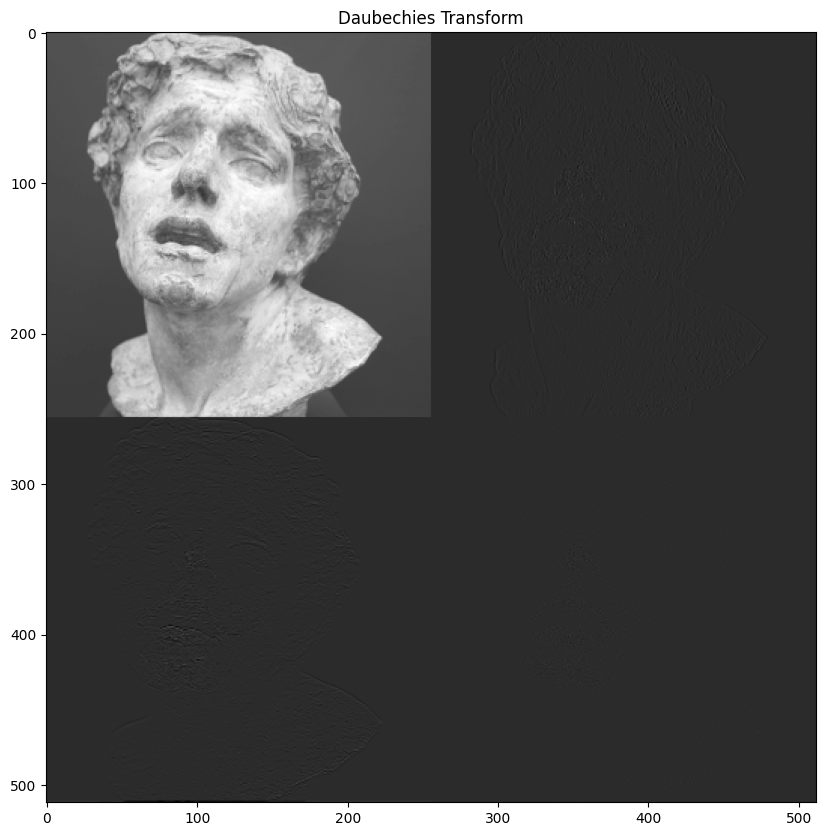

In [146]:
array_photo = jpg_to_pgm(photo)
daubechies_4 = function_daubechies_coeffs(array_photo)
result_img = daubechies4_wavelet_transform_2D(daubechies_4,array_photo,1,array_photo.shape[0])
# reconstructed = inverse_daubechies4_wavelet_transform_2D(daubechies_4,result_img)

imshow(result_img)

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.imshow(result_img, cmap='gray')
ax.set_title('Daubechies Transform')

# aP,cH,cV,cD = split_matrix(result_img)

# sup_img = np.concatenate((p_new(aP),p_new(cH)), axis=1)
# inf_img = np.concatenate((p_new(cV),p_new(cD)), axis=1)
# result_img = np.concatenate((sup_img,inf_img), axis=0)



##########
# fig, ax = plt.subplots(1, 3, figsize=(10, 10))
# ax[0].imshow(array_photo, cmap='gray')
# ax[0].set_title('Original')
# ax[1].imshow((result_img), cmap='gray')
# ax[1].set_title('Wavelet Transform')
# ax[2].imshow((reconstructed), cmap='gray')
# ax[2].set_title('Reconstructed')
# plt.show()

In [147]:
result_img = daubechies4_wavelet_transform_2D(daubechies_coeffs(aP),aP)

aP1,cH1,cV1,cD1 = split_matrix(result_img)
sup_img = np.concatenate((p_new(aP1),p_new(cH1)), axis=1)
inf_img = np.concatenate((p_new(cV1),p_new(cD1)), axis=1)
result_img = np.concatenate((sup_img,inf_img), axis=0)

sup_img = np.concatenate((result_img,p_new(cH)), axis=1)
inf_img = np.concatenate((p_new(cV),p_new(cD)), axis=1)
result_img = np.concatenate((sup_img,inf_img), axis=0)

fig, ax = plt.subplots(1, 2, figsize=(10, 10))
ax[0].imshow(array_photo, cmap='gray')
ax[0].set_title('Original')
ax[1].imshow((result_img), cmap='gray')
ax[1].set_title('Wavelet Transform')
plt.show()

TypeError: daubechies4_wavelet_transform_2D() missing 2 required positional arguments: 'scale' and 'width'

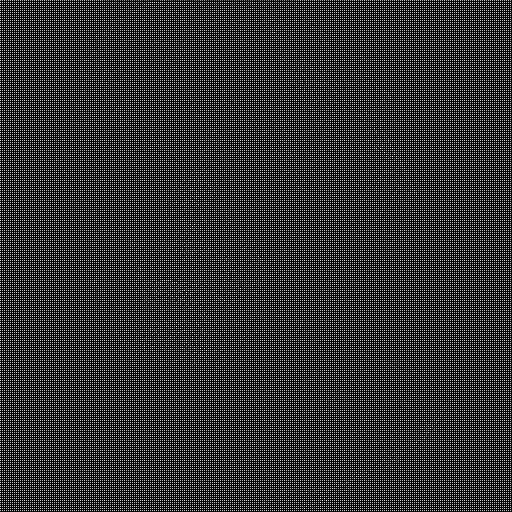

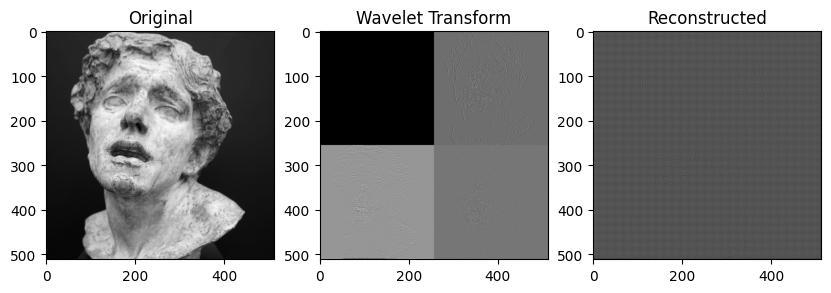

In [ ]:
array_photo = jpg_to_pgm(photo)
daubechies_4 = daubechies_coeffs(array_photo)
result_img = daubechies4_wavelet_transform_2D(daubechies_4,array_photo)
aP,cH,cV,cD = split_matrix(result_img2)
sup_img = np.concatenate((np.zeros_like(aP),cH), axis=1)
inf_img = np.concatenate((cV,cD), axis=1)
result_img = np.concatenate((sup_img,inf_img), axis=0)

reconstructed = inverse_daubechies4_wavelet_transform_2D(daubechies_4,result_img)

# sup_img = np.concatenate((np.zerosike(aP),p_new(cH)), axis=1)
# inf_img = np.concatenate((p_new(cV),p_new(cD)), axis=1)
# result_img = np.concatenate((sup_img,inf_img), axis=0)_l
imshow(reconstructed)

##########
fig, ax = plt.subplots(1, 3, figsize=(10, 10))
ax[0].imshow(array_photo, cmap='gray')
ax[0].set_title('Original')
ax[1].imshow((result_img), cmap='gray')
ax[1].set_title('Wavelet Transform')
ax[2].imshow((reconstructed), cmap='gray')
ax[2].set_title('Reconstructed')
plt.show()

## Others examples

In [ ]:
photo = 'mario.png'

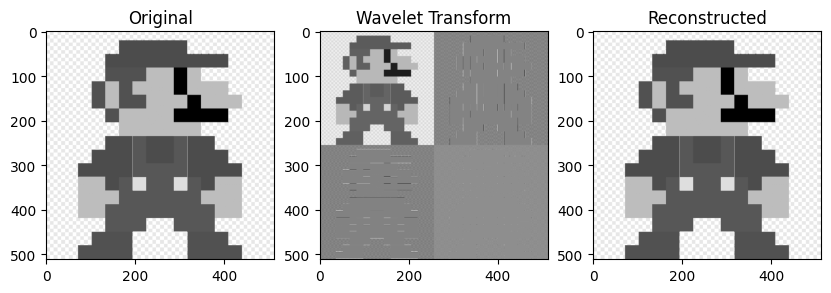

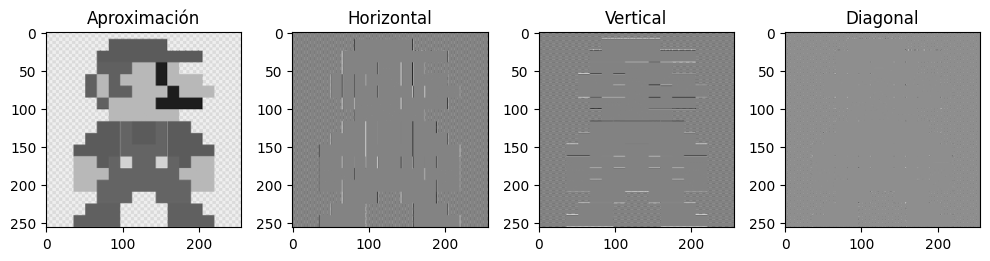

In [ ]:
array_photo = jpg_to_pgm(photo)
daubechies_4 = daubechies_coeffs(array_photo)
result_img2 = daubechies4_wavelet_transform_2D(daubechies_4,array_photo)
reconstructed = inverse_daubechies4_wavelet_transform_2D(daubechies_4,result_img2)

aP,cH,cV,cD = split_matrix(result_img2)

sup_img = np.concatenate((p_new(aP),p_new(cH)), axis=1)
inf_img = np.concatenate((p_new(cV),p_new(cD)), axis=1)
result_img2 = np.concatenate((sup_img,inf_img), axis=0)


##########
fig, ax = plt.subplots(1, 3, figsize=(10, 10))
ax[0].imshow(array_photo, cmap='gray')
ax[0].set_title('Original')
ax[1].imshow((result_img2), cmap='gray')
ax[1].set_title('Wavelet Transform')
ax[2].imshow((reconstructed), cmap='gray')
ax[2].set_title('Reconstructed')
plt.show()
#########
fig, axes = plt.subplots(1, 4, figsize=(10, 10))
axes[0].imshow(p_new(aP), cmap='gray')
axes[0].set_title('Aproximación')
axes[1].imshow(p_new(cH), cmap='gray')
axes[1].set_title('Horizontal')
axes[2].imshow(p_new(cV), cmap='gray')
axes[2].set_title('Vertical')
axes[3].imshow(p_new(cD), cmap='gray')
axes[3].set_title('Diagonal')

plt.tight_layout()
plt.show()

In [ ]:
photo = 'imagen2.jpeg'

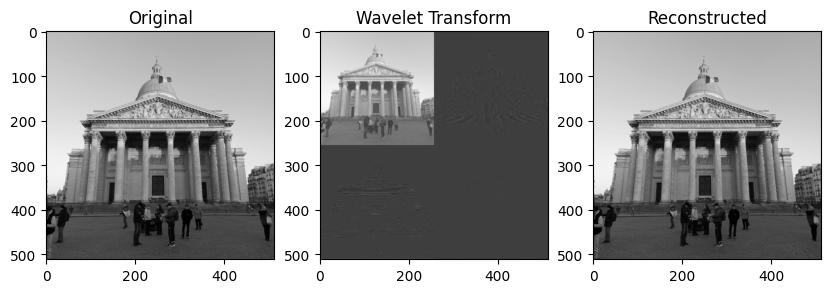

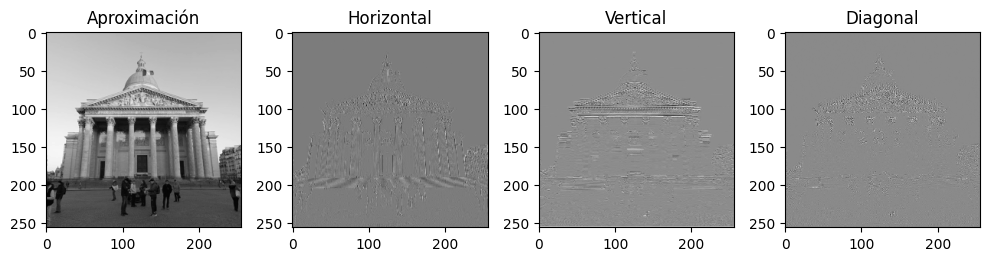

In [ ]:
array_photo = jpg_to_pgm(photo)
daubechies_4 = daubechies_coeffs(array_photo)
result_img2 = daubechies4_wavelet_transform_2D(daubechies_4,array_photo)
reconstructed = inverse_daubechies4_wavelet_transform_2D(daubechies_4,result_img2)

aP,cH,cV,cD = split_matrix(result_img2)

# sup_img = np.concatenate((p_new(aP),p_new(cH)), axis=1)
# inf_img = np.concatenate((p_new(cV),p_new(cD)), axis=1)
# result_img2 = np.concatenate((sup_img,inf_img), axis=0)


##########
fig, ax = plt.subplots(1, 3, figsize=(10, 10))
ax[0].imshow(array_photo, cmap='gray')
ax[0].set_title('Original')
ax[1].imshow((result_img2), cmap='gray')
ax[1].set_title('Wavelet Transform')
ax[2].imshow((reconstructed), cmap='gray')
ax[2].set_title('Reconstructed')
plt.show()
#########
fig, axes = plt.subplots(1, 4, figsize=(10, 10))
axes[0].imshow(p_new(aP), cmap='gray')
axes[0].set_title('Aproximación')
axes[1].imshow(p_new(cH), cmap='gray')
axes[1].set_title('Horizontal')
axes[2].imshow(p_new(cV), cmap='gray')
axes[2].set_title('Vertical')
axes[3].imshow(p_new(cD), cmap='gray')
axes[3].set_title('Diagonal')

plt.tight_layout()
plt.show()